In [346]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16, resnet34
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, AdamW
import torchvision.transforms as transforms
from transformers import get_linear_schedule_with_warmup,  get_cosine_schedule_with_warmup
from torch.nn import TransformerDecoderLayer, TransformerDecoder
import torch.nn.functional as F

import os
from tqdm import tqdm
import math

In [421]:
class Tokenizer():
    """
    A simple tokenier for character-level tokenization of singular words of arbitrary length.
    It maps each letter of the alphabet (lowercase and uppercase) to a unique integer ID.
    Introduces three special tokens - <EOS>, <BOS>, and <PAD> for end of sequence, beginning of sequence, and padding respectively.
    It is assumed that the labels (in this case, the captcha words) will be singular words without any spaces or numbers or any special characters.
    
    For now, the labels are assumed to be in lowercase letters only. But this will be changed to include uppercase letters as well.
    """
    def __init__(self):
        # define special tokens to indicate the beginning of a sequence, padding, and end of a sequence
        self.bos_token = '<BOS>'
        self.pad_token = '<PAD>'
        self.eos_token = '<EOS>'
        
        self.bos_token_id = 0
        self.pad_token_id = 1
        self.eos_token_id = 2
        
        # define the token-id mapping
        self.token_to_id = {chr(i): i - 97 + 3 for i in range(97, 123)} # for lowercase letters
        self.token_to_id.update({chr(i): i - 65 + 29 for i in range(65, 91)}) # for uppercase letters
        self.token_to_id[self.bos_token] = self.bos_token_id
        self.token_to_id[self.pad_token] = self.pad_token_id
        self.token_to_id[self.eos_token] = self.eos_token_id
        
        # define the id-token mapping
        self.id_to_token = {v: k for k, v in self.token_to_id.items()}
        
        # size of vocabulary of the model
        self.vocab_size = len(self.token_to_id)
    
    def tokenize(self, text):
        # Add special tokens and split text into characters
        tokens = [self.bos_token] + list(text) + [self.eos_token]
        return tokens

    def encode(self, text, padding=False, max_len=None):
        # Validate input and convert to list format
        if isinstance(text, str):
            texts = [text]
        elif isinstance(text, list):
            texts = text
        else:
            raise ValueError("Input must be a string or a list of strings.")
        
        

        # Tokenize all texts (with BOS/EOS)
        tokenized = [self.tokenize(t) for t in texts]
        
        # Convert to token IDs
        token_ids = [ [self.token_to_id.get(token) for token in tokens] for tokens in tokenized]
        
        # Handle padding and truncation
        if padding:
            # Determine max sequence length
            if max_len is None:
                max_len = max(len(seq) for seq in token_ids)
            else:
                # Ensure we can fit at least BOS + EOS
                max_len = max(max_len, 2)

            # Process each sequence
            processed = []
            for seq in token_ids:
                # Truncate first if needed
                if len(seq) > max_len:
                    # Preserve BOS and EOS while truncating
                    bos, eos = seq[0], seq[-1]
                    middle = seq[1:-1]
                    truncated_middle = middle[:max_len-2]
                    seq = [bos] + truncated_middle + [eos]
                    
                # Pad if needed
                if len(seq) < max_len:
                    pad_amount = max_len - len(seq)
                    seq = seq + [self.pad_token_id] * pad_amount
                    
                processed.append(seq)
            token_ids = processed

        # Always return 2D tensor (batch_size, seq_len)
        tensor = torch.tensor(token_ids, dtype=torch.long)
        return tensor
    
    def decode(self, token_ids):
        # convert ids to tokens
        if len(token_ids.shape) != 2:
            raise ValueError("Input must be a 2D tensor.")
        
            return None
        
        tokens = [[self.id_to_token.get(t.item(), self.pad_token) for t in item] for item in token_ids]
        # print("Tokens: ", tokens)
        
        # remove padding and special tokens
        
        tokens = [[t for t in items if t not in [self.pad_token, self.bos_token, self.eos_token]] for items in tokens]
        strings = [''.join(t) for t in tokens]
        
        return strings
    
    def get_vocab_size(self):
        return self.vocab_size    

In [382]:
text = ['Applepie', 'SwapnanilMukherjee']
tokenizer = Tokenizer()
# print(tokenizer.tokenize(text))
print(tokenizer.encode(text, padding=True, max_len=10), type(tokenizer.encode(text, padding=True, max_len=10)), tokenizer.encode(text, padding=True, max_len=10).shape)
print(tokenizer.decode(tokenizer.encode(text, padding=True, max_len=20)))

tensor([[ 0,  3, 18, 18, 14,  7, 18, 11,  7,  2],
        [ 0, 21, 25,  3, 18, 16,  3, 16, 11,  2]]) <class 'torch.Tensor'> torch.Size([2, 10])
['applepie', 'swapnanilmukherjee']


In [396]:
class VisionEncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, tokenizer, max_seq_len=10):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
        # Embedding and output layers
        self.d_model = self.decoder.layers[0].self_attn.embed_dim
        self.embedding = nn.Embedding(tokenizer.vocab_size, self.d_model)
        self.head = nn.Linear(self.d_model, tokenizer.vocab_size)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(self.d_model)
        
        # Register special tokens
        self.register_buffer('bos_token', torch.tensor([tokenizer.bos_token_id], dtype=torch.long))
        self.register_buffer('eos_token', torch.tensor([tokenizer.eos_token_id], dtype=torch.long))
        self.register_buffer('pad_token', torch.tensor([tokenizer.pad_token_id], dtype=torch.long))
        

    def encode(self, images):
        """Extract image features with ConvNeXt encoder"""
        features = self.encoder.stem(images)
        for stage in self.encoder.stages:
            features = stage(features)
        return features  # (B, C, H, W)

    def decode(self, features, tgt, tgt_mask=None):
        """Transformer decoder forward pass (batch-first)"""
        B, C, H, W = features.shape
        
        # Prepare encoder memory (B, H*W, C)
        memory = features.view(B, C, -1).permute(0, 2, 1)
        
        # Embed tokens and add positional encoding (B, S, E)
        x = self.embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        # Transformer decoder (batch-first)
        output = self.decoder(
            tgt=x,
            memory=memory,
            tgt_mask=tgt_mask,
            memory_key_padding_mask=None
        )
        
        return self.head(output)

    def forward(self, images, tgt, tgt_mask=None):
        features = self.encode(images)
        shifted_tgt = self._shift_right(tgt)
        
        # Generate causal mask if not provided
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(shifted_tgt.size(1))
            
        logits = self.decode(features, shifted_tgt, tgt_mask)
        return logits

    def _shift_right(self, input_ids):
        shifted = input_ids.clone()
        shifted[:, 1:] = input_ids[:, :-1]
        shifted[:, 0] = self.bos_token
        return shifted

    def generate_square_subsequent_mask(self, sz):
        """Create causal mask for decoder predictions (batch-first)"""
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    @torch.no_grad()
    def generate(self, images, max_length=None):
        max_length = max_length or self.max_seq_len
        B = images.size(0)
        device = images.device
        
        # Initialize with BOS tokens (B, 1)
        outputs = torch.full((B, max_length), self.pad_token.item(), 
                        dtype=torch.long, device=device)
        outputs[:, 0] = self.bos_token.item()
        
        # Track active sequences (haven't generated EOS yet)
        active_mask = torch.ones(B, dtype=torch.bool, device=device)
        
        for step in range(1, max_length):
            # Only continue for active sequences
            if not active_mask.any():
                break
                
            # Forward pass for active sequences only
            current_input = outputs[active_mask, :step]
            logits = self(images[active_mask], current_input)
            
            # Get next tokens (greedy)
            next_tokens = logits[:, -1, :].argmax(-1)
            
            # Update outputs and mask
            outputs[active_mask, step] = next_tokens
            active_mask[active_mask.clone()] = (next_tokens != self.eos_token)
            
        # Replace EOS tokens with padding after their first occurrence
        eos_positions = (outputs == self.eos_token).float().argmax(dim=1)
        for i in range(B):
            if eos_positions[i] > 0:  # Found EOS token
                outputs[i, eos_positions[i]+1:] = self.pad_token.item()
                
        return outputs

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        
        # Create positional encoding matrix
        position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * 
            (-math.log(10000.0) / d_model)
        )  # (d_model//2,)
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # (max_len, d_model//2)
        pe[:, 1::2] = torch.cos(position * div_term)  # (max_len, d_model//2)
        
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        """x: (B, S, E)"""
        return x + self.pe[:, :x.size(1)]

In [397]:
# Test causal masking
mask = model.generate_square_subsequent_mask(3)
print(mask)
# tensor([[0., -inf, -inf],
#         [0., 0., -inf],
#         [0., 0., 0.]])

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])


In [ ]:
# Example usage:
encoder = ConvNeXtCAPTCHA(num_classes=0)  # Remove classification head

# Create decoder with batch_first=True
decoder_layer = nn.TransformerDecoderLayer(
    d_model=256,
    nhead=8,
    dim_feedforward=1024,
    batch_first=True 
)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
tokenizer = Tokenizer()

model = VisionEncoderDecoder(
    encoder=encoder,
    decoder=decoder,
    tokenizer=tokenizer,
    max_seq_len=15
)

In [423]:
# Forward pass
images = torch.randn(3, 3, 300, 150)
labels = tokenizer.encode(["apple", "BANANA", "triage"], padding=True, max_len=15)
logits = model(images, labels[:, :-1])

# Calculate loss
loss = F.cross_entropy(
    logits.reshape(-1, tokenizer.vocab_size),
    labels[:, 1:].reshape(-1),
    ignore_index=tokenizer.pad_token_id
)

print(f"Loss: {loss.item():.4f}")

# Generate with beam width 5 and max length 15
output = model.generate(images, max_length=15)
decoded = tokenizer.decode(output)
print(decoded)

Loss: 4.3949
['MUuuJJuJJuuJJu', 'UJuuJJuusuusks', 'MJJJuuUJJuuJJu']


In [435]:
class CAPTCHADataset(Dataset):
    def __init__(self,  dir, label_file, label_map, transform=None, subset_qty=None):
        super(CAPTCHADataset, self).__init__()
        
        self.dir = dir
        self.label_file = pd.read_csv(os.path.join(os.path.curdir, label_file))
        if subset_qty != None:
            self.label_file = self.label_file.sample(subset_qty, axis=0).reset_index()
        self.label_map = label_map
        self.transform = transform

    def __getitem__(self, index):
        image_name = self.label_file['image'][index]
        image = Image.open(os.path.join(os.getcwd(), self.dir, image_name))
        
        label = self.label_file['label'][index]
        
        if self.transform != None:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.label_file)

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    
    try:
        # Encode labels using tokenizer
        labels = tokenizer.encode(list(labels), padding=True, max_len=15)
    except Exception as e:
        print(f"Error encoding labels: {e}")
        print("Labels: ", labels)
    
    return images, labels

In [425]:
labels = pd.read_csv('hard_set_labels.csv')['label'].unique().tolist()
print(len(labels))

numeric_labels = range(len(labels))

label_map = dict(zip(labels, numeric_labels))

19161


In [ ]:
train_transforms = transforms.Compose([

                                        transforms.Resize((150, 300)),
                                        transforms.RandomRotation(25),
                                        transforms.ColorJitter(saturation=[5, 15], hue=[-0.2, 0.2]),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[1.848086931276295, 1.8482869967014623, 1.848101962198446],
                                                             std = [0.319237245924657, 0.31864693591324456, 0.31901034284562513])
                                            ])

test_transforms = transforms.Compose([
                                        transforms.Resize((150, 300)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[1.848086931276295, 1.8482869967014623, 1.848101962198446],
                                                             std = [0.319237245924657, 0.31864693591324456, 0.31901034284562513])
                                            ])


In [478]:
generator = torch.Generator().manual_seed(42)
subset_size = 25000

easy_set = CAPTCHADataset(dir='easy_set', label_file='easy_set_labels.csv', label_map=label_map, transform=train_transforms, subset_qty=subset_size)
easy_set_train, easy_set_test = torch.utils.data.random_split(easy_set, lengths=[0.8, 0.2], generator=generator)

hard_set = CAPTCHADataset(dir='hard_set', label_file='hard_set_labels.csv', label_map=label_map, transform=train_transforms, subset_qty=subset_size)
hard_set_train, hard_set_test = torch.utils.data.random_split(hard_set, lengths=[0.8, 0.2], generator=generator)

bonus_set = CAPTCHADataset(dir='bonus_set', label_file='bonus_set_labels.csv', label_map=label_map, transform=train_transforms, subset_qty=None)
bonus_set_train, bonus_set_test = torch.utils.data.random_split(bonus_set, lengths=[0.8, 0.2], generator=generator)

train_data = torch.utils.data.ConcatDataset([easy_set_train, hard_set_train])
test_data = torch.utils.data.ConcatDataset([easy_set_test, hard_set_test])

# train_data, test_data = bonus_set_train, bonus_set_test

print("Number of training samples: ", len(train_data))
print("Number of testing samples: ", len(test_data))
print("Number of Easy train samples: ", len(easy_set_train)) 
print("Number of Hard train samples: ", len(hard_set_train))
print("Number of Easy test samples: ", len(easy_set_test)) 
print("Number of Hard test samples: ", len(hard_set_test))
print("Number of Classes: ", len(labels))

trainloader = DataLoader(train_data, batch_size=64, collate_fn=collate_fn, shuffle=True, pin_memory=True, num_workers=8)
testloader = DataLoader(test_data, batch_size=64, collate_fn=collate_fn, shuffle=True, pin_memory=True, num_workers=8)

Number of training samples:  40000
Number of testing samples:  10000
Number of Easy train samples:  20000
Number of Hard train samples:  20000
Number of Easy test samples:  5000
Number of Hard test samples:  5000
Number of Classes:  19161


In [479]:
device = 'cuda'

In [480]:
def train(model, tokenizer, dataloader, optimizer, scheduler):
    
    running_loss = 0.0
    nb_steps = 0
    
    for batch in tqdm(dataloader):
        images, labels = batch
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits = model(images, labels[:, :-1])
        curr_loss = F.cross_entropy(
                logits.reshape(-1, tokenizer.vocab_size),
                labels[:, 1:].reshape(-1),
                ignore_index=tokenizer.pad_token_id
            )
        
        curr_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler != None:
            scheduler.step()
        
        running_loss += curr_loss
        nb_steps += 1
    
    return running_loss / nb_steps

In [469]:
def exact_match_accuracy(tokenizer, generated_ids, true_texts, show_ouptuts=False):
    # Decode generated IDs to text
    generated_texts = tokenizer.decode(generated_ids)
    decoded_labels = tokenizer.decode(true_texts)
    
    if show_ouptuts:
        # show first five outputs of each batch
        print("Generated texts: ", generated_texts[:5])
        print("Decoded labels: ", decoded_labels[:5])
        print("=========================================================")
    
    # Compare each generated text with ground truth
    correct = 0
    for gen, true in zip(generated_texts, decoded_labels):
        # Remove any accidental whitespace and normalize case if needed
        gen_clean = gen.strip()  # Use lower() only if case-insensitive comparison 
        true_clean = true.strip()
        
        if gen_clean == true_clean:
            correct += 1
    
    return correct / len(true_texts)

def evaluate(model, tokenizer, dataloader, show_outputs=False):
    running_loss, running_acc = 0.0, 0.0
    nb_steps = 0
    
    for batch in dataloader:
        images, labels = batch
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.no_grad():
            output_ids = model.generate(images, max_length=15)
        
        curr_acc = exact_match_accuracy(tokenizer, output_ids, labels, show_outputs) 
        
        running_acc += curr_acc
        
        nb_steps += 1
    
    return running_acc/nb_steps


In [470]:
def run(epochs, model, tokenizer, optimizer, scheduler, trainloader, testloader, save_dir):
    
    best_ems = 0
    
    train_losses, val_ems = [], []
    
    print("Training started.")
    for epoch in range(epochs):
        print("=======================================================")
        print(f"Epoch {epoch}/{epochs}")
        
        train_loss = train(model, tokenizer, trainloader, optimizer, scheduler)
        print(f"Train loss: {train_loss}", end='\t\t')
        
        ems = evaluate(model, tokenizer, testloader)
        # print(f"Validation loss: {val_loss}", end='\t\t')
        print(f"Validation accuracy: {ems}")
        
        if ems > best_ems:
            print("Better model state found. Saving ...")
            torch.save(model.state_dict(), os.path.join('/home/swapnanil_mukherjee/captcha/checkpoints/', save_dir, "best_model.pth"))
            
            best_ems = ems
        
        train_losses.append(train_loss.cpu().item())
        # val_losses.append(val_loss.cpu().item())
        val_ems.append(ems)
        
    # return train_losses, val_losses, val_acc
    return train_losses, val_ems

In [481]:
# Example usage:
encoder = ConvNeXtCAPTCHA(num_classes=0)            # Remove classification head

decoder_layer = nn.TransformerDecoderLayer(
    d_model=256,
    nhead=8,
    dim_feedforward=1024,
    batch_first=True 
)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=8)
tokenizer = Tokenizer()
model = VisionEncoderDecoder(
    encoder=encoder,
    decoder=decoder,
    tokenizer=tokenizer,
    max_seq_len=15
).to(device)

# model.load_state_dict(torch.load(os.path.join('/home/swapnanil_mukherjee/captcha/checkpoints/vgg/', 'best_model.pth')))

print("Number of parameters, in million: ", sum(p.numel() for p in model.parameters())/1e6)

Number of parameters, in million:  11.634263


/home/swapnanil_mukherjee/captcha/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [482]:
epochs = 50

optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_training_steps=len(trainloader)*epochs, 
                                            num_warmup_steps=len(trainloader)*epochs*0.1)

# train_losses, val_losses, val_acc = run(epochs, model, tokenizer, optimizer, scheduler, trainloader, testloader, save_dir="vgg")
train_losses, val_ems = run(epochs, model, tokenizer, optimizer, scheduler, trainloader, testloader, save_dir="vgg")

Training started.
Epoch 0/50


100%|██████████| 625/625 [00:56<00:00, 11.09it/s]

Train loss: 3.384094476699829		

Validation accuracy: 0.0
Epoch 1/50


100%|██████████| 625/625 [00:57<00:00, 10.92it/s]


Train loss: 2.654900312423706		Validation accuracy: 9.952229299363058e-05
Better model state found. Saving ...
Epoch 2/50


100%|██████████| 625/625 [00:57<00:00, 10.90it/s]


Train loss: 1.911712646484375		Validation accuracy: 0.0
Epoch 3/50


100%|██████████| 625/625 [00:57<00:00, 10.91it/s]


Train loss: 1.571650505065918		Validation accuracy: 9.952229299363058e-05
Epoch 4/50


100%|██████████| 625/625 [00:57<00:00, 10.94it/s]


Train loss: 1.3792215585708618		Validation accuracy: 0.023387738853503183
Better model state found. Saving ...
Epoch 5/50


100%|██████████| 625/625 [00:57<00:00, 10.92it/s]


Train loss: 1.122604250907898		Validation accuracy: 0.07523885350318471
Better model state found. Saving ...
Epoch 6/50


100%|██████████| 625/625 [00:57<00:00, 10.85it/s]


Train loss: 1.0200471878051758		Validation accuracy: 0.08499203821656051
Better model state found. Saving ...
Epoch 7/50


100%|██████████| 625/625 [00:57<00:00, 10.86it/s]


Train loss: 0.9651203155517578		Validation accuracy: 0.09036624203821655
Better model state found. Saving ...
Epoch 8/50


100%|██████████| 625/625 [00:57<00:00, 10.94it/s]


Train loss: 0.9109057188034058		Validation accuracy: 0.09046576433121019
Better model state found. Saving ...
Epoch 9/50


100%|██████████| 625/625 [00:57<00:00, 10.94it/s]


Train loss: 0.8578007817268372		Validation accuracy: 0.09006767515923567
Epoch 10/50


100%|██████████| 625/625 [00:57<00:00, 10.91it/s]


Train loss: 0.8073672652244568		Validation accuracy: 0.09554140127388536
Better model state found. Saving ...
Epoch 11/50


100%|██████████| 625/625 [00:57<00:00, 10.86it/s]


Train loss: 0.7589545249938965		Validation accuracy: 0.09424761146496816
Epoch 12/50


100%|██████████| 625/625 [00:57<00:00, 10.93it/s]


Train loss: 0.7138652205467224		Validation accuracy: 0.1035031847133758
Better model state found. Saving ...
Epoch 13/50


100%|██████████| 625/625 [00:52<00:00, 11.84it/s]


Train loss: 0.6660852432250977		Validation accuracy: 0.10698646496815287
Better model state found. Saving ...
Epoch 14/50


100%|██████████| 625/625 [00:52<00:00, 11.80it/s]


Train loss: 0.6203513145446777		Validation accuracy: 0.11843152866242038
Better model state found. Saving ...
Epoch 15/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.573005199432373		Validation accuracy: 0.16152468152866242
Better model state found. Saving ...
Epoch 16/50


100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


Train loss: 0.5157063603401184		Validation accuracy: 0.37649283439490444
Better model state found. Saving ...
Epoch 17/50


100%|██████████| 625/625 [00:53<00:00, 11.62it/s]


Train loss: 0.39319923520088196		Validation accuracy: 0.5577229299363057
Better model state found. Saving ...
Epoch 18/50


100%|██████████| 625/625 [00:52<00:00, 11.87it/s]


Train loss: 0.31123092770576477		Validation accuracy: 0.5901671974522293
Better model state found. Saving ...
Epoch 19/50


100%|██████████| 625/625 [00:52<00:00, 11.83it/s]


Train loss: 0.26145699620246887		Validation accuracy: 0.6224124203821656
Better model state found. Saving ...
Epoch 20/50


100%|██████████| 625/625 [00:52<00:00, 11.87it/s]


Train loss: 0.22645768523216248		Validation accuracy: 0.6480891719745223
Better model state found. Saving ...
Epoch 21/50


100%|██████████| 625/625 [00:52<00:00, 11.82it/s]


Train loss: 0.19605135917663574		Validation accuracy: 0.6744625796178344
Better model state found. Saving ...
Epoch 22/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.17170026898384094		Validation accuracy: 0.6979498407643312
Better model state found. Saving ...
Epoch 23/50


100%|██████████| 625/625 [00:57<00:00, 10.90it/s]


Train loss: 0.15379150211811066		Validation accuracy: 0.7131767515923567
Better model state found. Saving ...
Epoch 24/50


100%|██████████| 625/625 [00:52<00:00, 11.87it/s]


Train loss: 0.1376924216747284		Validation accuracy: 0.7302945859872612
Better model state found. Saving ...
Epoch 25/50


100%|██████████| 625/625 [00:53<00:00, 11.79it/s]


Train loss: 0.12221433967351913		Validation accuracy: 0.7468152866242038
Better model state found. Saving ...
Epoch 26/50


100%|██████████| 625/625 [00:53<00:00, 11.79it/s]


Train loss: 0.10932277888059616		Validation accuracy: 0.7604498407643312
Better model state found. Saving ...
Epoch 27/50


100%|██████████| 625/625 [00:53<00:00, 11.75it/s]


Train loss: 0.10056126117706299		Validation accuracy: 0.7653264331210191
Better model state found. Saving ...
Epoch 28/50


100%|██████████| 625/625 [00:52<00:00, 11.80it/s]


Train loss: 0.09075511246919632		Validation accuracy: 0.7827428343949044
Better model state found. Saving ...
Epoch 29/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.0837593823671341		Validation accuracy: 0.7918988853503185
Better model state found. Saving ...
Epoch 30/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.07485874742269516		Validation accuracy: 0.8023487261146497
Better model state found. Saving ...
Epoch 31/50


100%|██████████| 625/625 [00:52<00:00, 11.83it/s]


Train loss: 0.06901305913925171		Validation accuracy: 0.8171775477707006
Better model state found. Saving ...
Epoch 32/50


100%|██████████| 625/625 [00:52<00:00, 11.84it/s]


Train loss: 0.06419527530670166		Validation accuracy: 0.8171775477707006
Epoch 33/50


100%|██████████| 625/625 [00:52<00:00, 11.80it/s]


Train loss: 0.0594935417175293		Validation accuracy: 0.8237460191082803
Better model state found. Saving ...
Epoch 34/50


100%|██████████| 625/625 [00:52<00:00, 11.82it/s]


Train loss: 0.05533077195286751		Validation accuracy: 0.8342953821656051
Better model state found. Saving ...
Epoch 35/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.05054885149002075		Validation accuracy: 0.8463375796178344
Better model state found. Saving ...
Epoch 36/50


100%|██████████| 625/625 [00:53<00:00, 11.79it/s]


Train loss: 0.047772977501153946		Validation accuracy: 0.8455414012738853
Epoch 37/50


100%|██████████| 625/625 [00:52<00:00, 11.83it/s]


Train loss: 0.044970571994781494		Validation accuracy: 0.8492237261146497
Better model state found. Saving ...
Epoch 38/50


100%|██████████| 625/625 [00:52<00:00, 11.85it/s]


Train loss: 0.04290131852030754		Validation accuracy: 0.8558917197452229
Better model state found. Saving ...
Epoch 39/50


100%|██████████| 625/625 [00:52<00:00, 11.83it/s]


Train loss: 0.040083590894937515		Validation accuracy: 0.8589769108280255
Better model state found. Saving ...
Epoch 40/50


100%|██████████| 625/625 [00:52<00:00, 11.80it/s]


Train loss: 0.03814873844385147		Validation accuracy: 0.8596735668789809
Better model state found. Saving ...
Epoch 41/50


100%|██████████| 625/625 [00:53<00:00, 11.78it/s]


Train loss: 0.036769066005945206		Validation accuracy: 0.8672372611464968
Better model state found. Saving ...
Epoch 42/50


100%|██████████| 625/625 [00:52<00:00, 11.83it/s]


Train loss: 0.035886041820049286		Validation accuracy: 0.86046974522293
Epoch 43/50


100%|██████████| 625/625 [00:52<00:00, 11.84it/s]


Train loss: 0.0338088721036911		Validation accuracy: 0.8652468152866242
Epoch 44/50


100%|██████████| 625/625 [00:52<00:00, 11.80it/s]


Train loss: 0.03337567299604416		Validation accuracy: 0.8657444267515924
Epoch 45/50


100%|██████████| 625/625 [00:53<00:00, 11.77it/s]


Train loss: 0.03232404589653015		Validation accuracy: 0.8664410828025477
Epoch 46/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.03177764266729355		Validation accuracy: 0.8689291401273885
Better model state found. Saving ...
Epoch 47/50


100%|██████████| 625/625 [00:52<00:00, 11.86it/s]


Train loss: 0.03152833506464958		Validation accuracy: 0.8695262738853503
Better model state found. Saving ...
Epoch 48/50


100%|██████████| 625/625 [00:52<00:00, 11.81it/s]


Train loss: 0.03164296969771385		Validation accuracy: 0.8690286624203821
Epoch 49/50


100%|██████████| 625/625 [00:52<00:00, 11.83it/s]


Train loss: 0.030839143320918083		Validation accuracy: 0.8707205414012739
Better model state found. Saving ...


In [ ]:
evaluate(model, tokenizer, testloader, show_outputs=True)

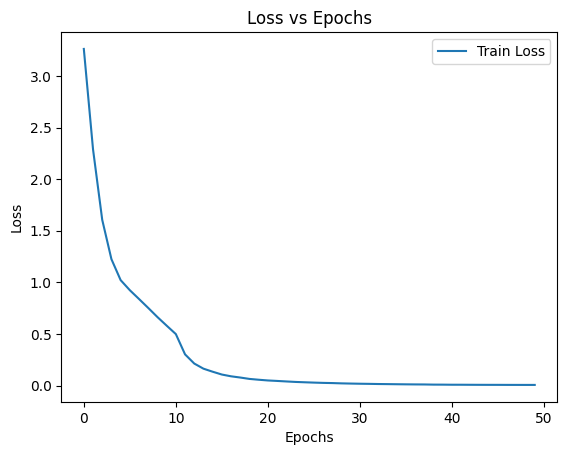

In [452]:
plt.plot(range(epochs), train_losses, label='Train Loss')
# plt.plot(range(epochs), val_losses, label= 'Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.show()

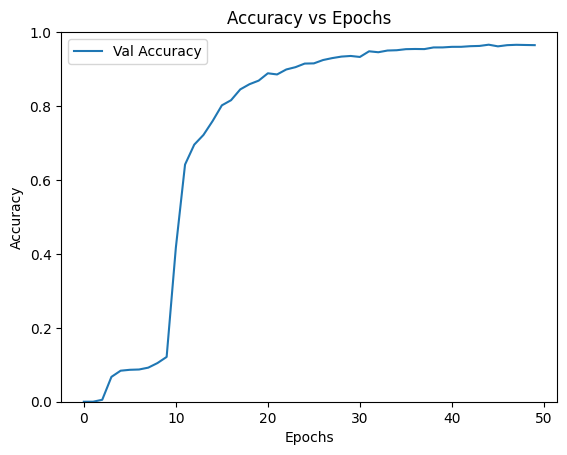

In [453]:
plt.plot(range(epochs), val_ems, label= 'Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.ylim(0, 1)
plt.legend()
plt.show()